In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import pandas as pd
import math
import ipywidgets as widgets
from IPython.display import display
from  ipywidgets  import interact, interactive, fixed, interact_manual
sys.path.append("/home/azureuser/Documents/EulerTurbine/model/")
from CoolProp.CoolProp import PropsSI
import CoolProp.CoolProp as CP

from create_figures import *

In [28]:
dfturbine = pd.read_csv("/home/azureuser/Documents/EulerTurbine/data/EulerTurbineData.txt", sep='\t')
dfturbine['omegaHz'] = dfturbine['omega'].apply(lambda x: x / (2 * math.pi))
alpha1_vec = dfturbine['state1_kinematic_alpha'].unique()
h2_vec = dfturbine['state2_height'].unique()
alpha2_vec = dfturbine['state2_kinematic_alpha'].unique()
omega_vec = dfturbine['omegaHz'].sort_values().unique()
R_vec = dfturbine['R'].sort_values().unique()
h2_vec = dfturbine['state2_height'].sort_values().unique()
P1_vec = dfturbine['state1_thermodynamic_static_P'].sort_values().unique()
P2_vec = dfturbine['state2_thermodynamic_static_P'].sort_values().unique()
a3_vec = dfturbine['state3_area'].sort_values().unique()
P3_vec = dfturbine['state3_thermodynamic_static_P'].sort_values().unique()
P4_vec = dfturbine['state4_thermodynamic_static_P'].sort_values().unique()
eta1_vec = dfturbine['eta1'].sort_values().unique()
eta2_vec = dfturbine['eta2'].sort_values().unique()

dfnotopti = dfturbine[dfturbine['optimized'] == False]
dfopti = dfturbine[dfturbine['optimized']]
h3_vec = dfopti['state3_height'].unique()*1e3
h3_vec2 = dfnotopti['state3_height'].sort_values().unique()*1e3

In [21]:
#creating contour for compressability
#domain
nT = 100
Tmin = 273.15
Tmax = 650
T = np.linspace(Tmin, Tmax, nT)
nS = 100
Smin = 850
Smax = 1500
S = np.linspace(Smin, Smax, nS)
nH = 100
Hmin = 200*1e3#PropsSI("H", "T", Tmin, "S", Smin, 'Toluene')
Hmax = 700*1e3 #psSI("H", "T", Tmax, "S", Smax, 'Toluene')
H = np.linspace(Hmin, Hmax, nH)
#creating contour
dftemp = pd.DataFrame(H, columns=['H'])
dfentr = pd.DataFrame(S, columns=['S'])
dftemp['key'] = 1
dfentr['key'] = 1
df = dftemp.merge(dfentr, how='outer')[['S', 'H']]
df['Z'] = df.apply(lambda x: PropsSI('Z', 'H', x['H'], 'S', x['S'], 'Toluene'), axis=1)
df['phase'] = df.apply(lambda x: PropsSI('Phase', 'H', x['H'], 'S', x['S'],'Toluene'), axis=1)
gas = df['phase'] == CP.get_phase_index('phase_gas')
supercritical_gas = df['phase'] == CP.get_phase_index('phase_supercritical_gas')
df_contour = df[gas | supercritical_gas][['H', "S", "Z"]]
df_contour['H']=df_contour['H']*1e-3
df_contour['S']=df_contour['S']*1e-3
criticalisobar = PropsSI("T", "P", CP.PropsSI("Pcrit", "Toluene"), "S", S, 'Toluene')
dome1 = PropsSI("S", "T", T, "Q", 1., 'Toluene')
dome2 = PropsSI("S", "T", T, "Q", 0., 'Toluene')
dome1 = PropsSI("S", "T", T, "Q", 1., 'Toluene')
dome2 = PropsSI("S", "T", T, "Q", 0., 'Toluene')
dome1h=[]
dome2h=[]
for index, element in enumerate(dome1):
    try:
        dome1h.append(PropsSI("H", "T", T[index], "S", element, 'Toluene'))
    except:
        dome1h.append(float('Inf'))
for index, element in enumerate(dome2):
    try:
        dome2h.append(PropsSI("H", "T", T[index], "S", element, 'Toluene'))
    except:
        dome2h.append(float('Inf'))
dome1h = np.asarray(dome1h)
dome2h = np.asarray(dome2h)

In [22]:
#creating isobars
dfs = []
for i in P3_vec:
    df=pd.DataFrame()
    df['H'] = PropsSI("H", "P", i, "S", S, 'Toluene')*1e-3
    df['P'] = i
    dfs.append(df)
df_isobarP3 = pd.concat(dfs)
dfs = []
for j in P2_vec:
    df=pd.DataFrame()
    df['H'] = PropsSI("H", "P", j, "S", S, 'Toluene')*1e-3
    df['P'] = j
    dfs.append(df)
df_isobarP2 = pd.concat(dfs)
dfs = []
for k in P1_vec:
    df=pd.DataFrame()
    df['H'] = PropsSI("H", "P", k, "S", S, 'Toluene')*1e-3
    df['P'] = k
    dfs.append(df)
df_isobarP1 = pd.concat(dfs)

for k in P4_vec:
    df=pd.DataFrame()
    df['H'] = PropsSI("H", "P", k, "S", S, 'Toluene')*1e-3
    df['P'] = k
    dfs.append(df)
df_isobarP4 = pd.concat(dfs)




In [29]:
def plot(P2, P3, omegaHz, h3,eta1,eta2 ):
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,9))
    plot_velocity_triangles(ax1,P2, P3, omegaHz, h3,eta1,eta2)
    plot_diagram(ax2, P2, P3, omegaHz, h3,eta1,eta2)
    plt.show()

In [30]:
def plot_velocity_triangles(ax,P2, P3, omegaHz, h3,eta1,eta2 ):
    
    data = filter_df_6cols(dfnotopti, 
                           'state2_thermodynamic_static_P',P2,
                           'state3_thermodynamic_static_P',P3,
                           'omegaHz',omegaHz,
                           'state3_height',h3*1e-3,
                           'eta1',eta1,
                           'eta2',eta2
                          )
    originstatorinlet = [0, 0]
    originrotorinlet = [150, 0]
    originrotoroutlet = [500, 0]
    #fig, ax = plt.subplots()

    line1 = ax.quiver(originrotorinlet[0], originrotorinlet[1],
              data['state2_kinematic_c_r'], data['state2_kinematic_c_theta'],
              color='r', scale=1, angles='xy', scale_units="xy")
    line2 = ax.quiver(originrotorinlet[0] + data['state2_kinematic_w_r'], data['state2_kinematic_w_theta'],
              data['state2_kinematic_u_r'], data['state2_kinematic_u_theta'],
              color='g', scale=1, angles='xy', scale_units="xy")
    line3 = ax.quiver(originrotorinlet[0], originrotorinlet[1],
              data['state2_kinematic_w_r'], data['state2_kinematic_w_theta'],
              color='b', scale=1, angles='xy', scale_units="xy")


    line4 = ax.quiver(originrotoroutlet[0], originrotoroutlet[1],
              data['state3_kinematic_c_r'], data['state3_kinematic_c_theta'],
              color='r', scale=1, angles='xy', scale_units="xy")
    line5 = ax.quiver(originrotoroutlet[0] + data['state3_kinematic_w_r'], data['state3_kinematic_w_theta'],
              data['state3_kinematic_u_r'], data['state3_kinematic_u_theta'],
              color='g', scale=1, angles='xy', scale_units="xy")
    line6 = ax.quiver(originrotoroutlet[0], originrotoroutlet[1],
              data['state3_kinematic_w_r'], data['state3_kinematic_w_theta'],
              color='b', scale=1, angles='xy', scale_units="xy")

    #self.state2.kinematic.draw_with_c(ax, originrotorinlet)
    #self.state3.kinematic.draw_with_w(ax, originrotoroutlet)
    ax.set_xlim([0, 1000])
    ax.set_ylim([-1000, 1000])


In [31]:
def plot_diagram(ax, P2, P3, omegaHz, h3,eta1,eta2):
    data = filter_df_6cols(dfnotopti, 
                           'state2_thermodynamic_static_P',P2,
                           'state3_thermodynamic_static_P',P3,
                           'omegaHz',omegaHz,
                           'state3_height',h3*1e-3,
                           'eta1',eta1,
                           'eta2',eta2
                          )
    #creating isobars
    isoP1 = data['state1_thermodynamic_static_P'].values[0]
    isoP2 = data['state2_thermodynamic_static_P'].values[0]
    isoP3 = data['state3_thermodynamic_static_P'].values[0]
    isoP4 = data['state4_thermodynamic_static_P'].values[0]

#     print(P1)
    stator_inlet = df_isobarP1[df_isobarP1['P']==isoP1]['H'].values
    stator_outlet =  df_isobarP2[df_isobarP2['P']==isoP2]['H'].values
    rotor_outlet = df_isobarP3[df_isobarP3['P']==isoP3]['H'].values
    condensor_inlet = df_isobarP4[df_isobarP4['P']==isoP4]['H'].values

    
    
    H1=data['state1_thermodynamic_static_H'].values[0]
    H2=data['state2_thermodynamic_static_H'].values[0]
    H3=data['state3_thermodynamic_static_H'].values[0]
    H4=data['state4_thermodynamic_static_H'].values[0]
    H01=data['state1_thermodynamic_total_H'].values[0]
    H03=data['state3_thermodynamic_total_H'].values[0]
    S1=data['state1_thermodynamic_static_S'].values[0]
    S2=data['state2_thermodynamic_static_S'].values[0]
    S3=data['state3_thermodynamic_static_S'].values[0]
    S4=data['state4_thermodynamic_static_S'].values[0]

    #condenser_inlet = PropsSI("H", "P", P4, "S", S, 'Toluene')*1e-3

    hdfpivot = df_contour.pivot('H', 'S')
    X = hdfpivot.columns.levels[1].values
    Y = hdfpivot.index.values
    Z = hdfpivot.values
    Xi, Yi = np.meshgrid(X, Y)

    #fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(S*1e-3, H01*np.ones(np.size(S))*1e-3, color='black', linestyle=':')
    ax.plot(S*1e-3, H03*np.ones(np.size(S))*1e-3, color='black', linestyle=':')


    ax.plot(S*1e-3, stator_inlet, color='black', linestyle='--')
    ax.plot(S*1e-3, stator_outlet, color='black', linestyle='--')
    ax.plot(S*1e-3, rotor_outlet, color='black', linestyle='--')
    ax.plot(S*1e-3, condensor_inlet, color='black', linestyle='--')


    # dome
    ax.plot(dome1*1e-3, dome1h*1e-3, color='black')
    ax.plot(dome2*1e-3, dome2h*1e-3, color='black')

    # process
    #ax.plot([S1*1e-3,S2*1e-3, S3*1e-3], [H1*1e-3,H2*1e-3,H3*1e-3], color='black', marker="X")
    ax.plot([S1*1e-3,S2*1e-3, S3*1e-3,S4*1e-3], [H1*1e-3,H2*1e-3,H3*1e-3,H4*1e-3], color='black', marker="X")
    #isentropic process
#     ax.plot([S1*1e-3,S2s*1e-3], [H1*1e-3,H2s*1e-3], color='black', marker="o")
#     ax.plot([S2*1e-3,S3s*1e-3], [H2*1e-3,H3s*1e-3], color='black', marker="o")

    # compressibility
    fig2 = ax.contourf(Xi, Yi, Z, 25, alpha=0.7, cmap=plt.cm.jet)
    ax.set_xlim([.850, 1.5])
    ax.ticklabel_format(fontsize=20)
    ax.set_ylim([200, 700])
    ax.set_xlabel(r'Entropy [KJ/kgK]', fontsize=15)
    ax.set_ylabel(r'Enthalpy [KJ/kg]', fontsize=15)
    cb = plt.colorbar(fig2)
    cb.set_label(r"Compressibility factor [-]", fontsize=15)


A Jupyter Widget

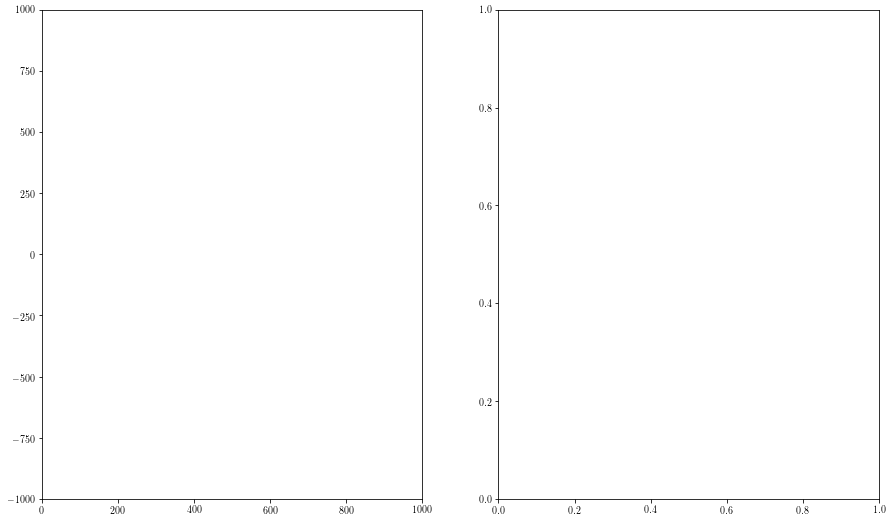

In [32]:

y=interactive(plot,  
              P3=(P3_vec[0],P3_vec[-1],np.diff(P3_vec)[0]),
              P2=(P2_vec[0],P2_vec[-1],np.diff(P2_vec)[0]),
              omegaHz=(omega_vec[0],omega_vec[-1],np.diff(omega_vec)[0]),
              h3=(h3_vec2[0],h3_vec2[-1],np.diff(h3_vec2)[0]),
              eta1=(eta1_vec[0],eta1_vec[-1],np.diff(eta1_vec)[0]),
              eta2=(eta2_vec[0],eta2_vec[-1],np.diff(eta2_vec)[0])
             )
display(y)